<span style=" font-size:3em;">MOD600 23V | Mandatory Project B</span>

<span style=" font-size:2em;">NUMERICAL SOLUTION OF SHALLOW WATER EQUATION USING ROE MATRIX</span>

<span style=" font-size:1.5em;"> Daniel Fylling </span>  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
%matplotlib inline

In [2]:
# Spatial grid, unit of x is meters
x_min = -25
x_max = 25
length = x_max - x_min
nx = 100
dx = length/nx
x = np.linspace(x_min - dx/2, x_max + dx/2, nx + 2) # including x_0 and x_n+1

# Gravitational constant
g = 9.81

# Temporal grid, units of t is seconds
t_final = 100

# Constant a = 1/2v_max = 1/(2*(2*g*h)^0.5), where h = h_max = 2 - 1 = 1
# using factor of 4 to ensure time step is small enough.
a = 1/(8*np.sqrt(2*g))
#a = 1/12
dt = dx * a
nt = int(t_final/dt)

# h - useful quantity for the numerical calculation
h = dt/dx

# Define vector for initial data, used for numerical calculation
h0 = np.zeros(nx + 2)
left = x < 0
right = x >= 0
h0[left] = 2
h0[right] = 1

v0 = np.zeros(nx + 2)

u_0 = np.array([h0 , h0*v0])



In [3]:
u_old = u_0.copy()
u_new = u_0.copy()
h_all = u_0[0, :]

for j in range(nt-1):
    for i in range(nx):
        i = i + 1

        # Define u_l and u_r Eq. (315)
        hl = u_old[0, i]
        hr = u_old[0, i+1]
        vl = u_old[1, i] / u_old[0, i]
        vr = u_old[1, i+1] / u_old[0, i+1] 

        # Find h_hat and v_hat
        h_hat = 0.5*(hl + hr) # Eq. (323)
        v_hat = (np.sqrt(hl)*vl + np.sqrt(hr)*vr) / (np.sqrt(hl) + np.sqrt(hr)) # Eq. (326)

        # Set up Roe Matrix Eq. (316)
        A_hat = np.zeros((2,2))
        A_hat[0, 1] = 1
        A_hat[1, 0] = g*h_hat - np.square(v_hat)
        A_hat[1, 1] = 2*v_hat

        # Find R_hat and Lambda, L
        L, R_hat = np.linalg.eig(A_hat) # Eq. (280)

        # Find A_hat_plus and A_hat_minus
        l_p = L.copy()
        mask = L < 0
        l_p[mask] = 0 # Eq. (287)
        L_p = np.diag(l_p) # Eq. (290)

        R_hat_inv = np.linalg.inv(R_hat) # Eq. (294)

        A_hat_p = np.linalg.multi_dot((R_hat, L_p, R_hat_inv)) # Eq. (298)
        A_hat_m = A_hat - A_hat_p # Eq. (291)

        # Solve Roe Scheme for current x-position, Eq. (303)
        u_new[:, i] = u_old[:, i] - h * (np.dot(A_hat_p, u_old[:, i] - u_old[:, i-1]) + np.dot(A_hat_m, u_old[:, i+1] - u_old[:, i]))

    # Boundary conditions as given in assignment
    # Left side
    u_new[:, 0] = [u_old[0, 1], -u_old[1, 1]]

    # Right side
    u_new[:, -1] = [u_old[0, -2], -u_old[1, -2]]

    h_all = np.c_[h_all, u_new[0, :]]
    u_old = u_new



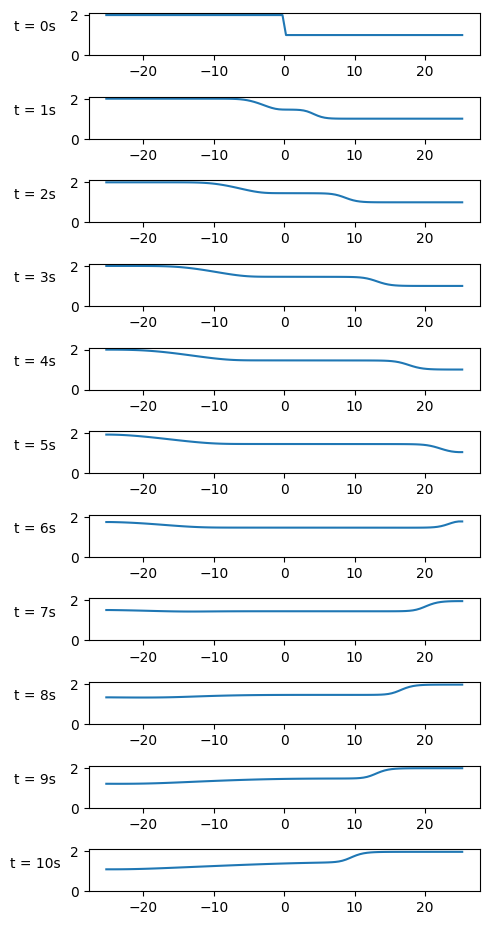

In [4]:
# Showing plots for each second for the first 10 seconds:

plt.figure(figsize=(5,25))

nt_all = np.arange(0, nt, int(nt/99))

for i, nti in enumerate(nt_all):

    plt.subplot(30,1,i+1)
    plt.plot(x, h_all[:,nti])
    plt.ylabel(f"t = {nti*dt:.0f}s", rotation=0, labelpad=25)
    plt.ylim(0,2.1)

    if nti*dt > 10:
        break

plt.tight_layout()

Text(0, 0.5, 'Mass equivalent')

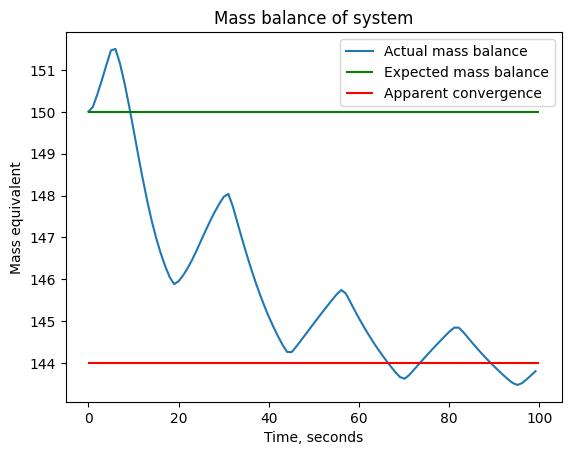

In [5]:
# Plotting to investigate adherence to conservation of mass:

plt.plot(nt_all*dt, np.sum(h_all[1:-1,:],0)[nt_all], label ='Actual mass balance')
plt.hlines(np.sum(h0[1:-1]), 0, 100, 'g', label ='Expected mass balance')
plt.hlines(144, 0, 100, 'r', label ='Apparent convergence')
plt.title('Mass balance of system')
plt.legend()
plt.xlabel('Time, seconds')
plt.ylabel('Mass equivalent')

On mass balance:

As can be seen in plot above the solution does not conserve mass too well. The mass of the system seems to converge to a point 6 [units] below starting value. The unit in this case is actually height in meters as the values are simply the sum of all heights in each time step. Based on the plot I suspect something is wrong with my model, as I would not expect such a big discrepancy at the relatively high resolution the simulation is running at. Sensitivity analysis has not been performed toward this issue as I think it's more likely some other oversight of mine that causes this.

In [7]:
# Using the Web-viewer has been the most reliable way for me to make animations in python, however it is not very stable. 
# Restrating the python kernel and rerunning the full code after changing something helps stability of output animation a lot.

u0 = u_0[0, :]
u_all = h_all

matplotlib.use('WebAgg')

fig, ax = plt.subplots()
line, = ax.plot(x,u0)

def init(): 
    line.set_data(x, u0)
    return line,

def animate(i):
    line.set_data(x, u_all[:,i])  # update the data.
    ax.set_title(f"t = {i*dt:.2f}")
    return line,

plt.plot(x,u_all[:,0],'--r')
ani = animation.FuncAnimation(fig, animate, init_func = init, frames = nt, interval = 25, blit=True)

plt.show()

On varying time step, dt:

It was observed that simulation seems to speed up with decreasing dt. In other words the wave travels further in a given time at a higher time resolution, compared to lower resolution. I speculate that this is related to speed of information. In each time step, information is only allowed to travel ONE spatial grid step, as the input required for calculating U(x) is limited to its closest neighbors. So with lesser time steps it takes less absolute time for information to travel across the grid. This made me think about the viscosity of the fluid in the simulation, and how I cannot explain how that is taken into consideration here.

On varying spatial resolution, dx:

While increasing spatial resolution (dt is adjusted automatically to keep simulation stable), it was observed that the wave front became very steep. This makes sense to me based on the equation we use to solve. Each calculation (in the x-t-space) does not know what dx is, it only knows h = dt/dx. Since dt is proportional to dx, this means that h is constant. Since each calculation processes a certain difference between nodes in the previous time step it makes sense for a certain transition to occupy a similar number of nodes rather than a certain absolute distance in this model. This again makes me very uncertain about how viscosity is accounted for in this model.

Reflection:

Most problems can be overcome by splitting the problem into sufficiently small problems that one is able to solve separately. This was my approach for this project. When reassembled he result is then something too complex for me to fully understand. This makes it difficult to comment properly on the behaviour of the model. Are my observations telling me something of the nature of handling such systems or are they related to errors in my code? I don't know, but often the goal is the journey rather than the destination. Or is that only something I tell myself when the destination was not quite what I expected? Hmm, I guess I don't know that either :)